## Cluster trees function

In [1]:
using JuMP, Gurobi, GLM, DataFrames, Plots, Clustering

In [21]:
using ScikitLearn, StatsBase
# Load in the DecisionTreeClassifier method from ScikitLearn
@sk_import tree: DecisionTreeClassifier;

LoadError: [91mFailed to import required Python module sklearn.

For automated sklearn installation, try configuring PyCall to use the Conda.jl package's Python "Miniconda" distribution within Julia. Relaunch Julia and run:
    ENV["PYTHON"]=""
    Pkg.build("PyCall")
before trying again.

The pyimport exception was: PyError (ccall(@pysym(:PyImport_ImportModule), PyPtr, (Cstring,), name)

The Python package sklearn could not be found by pyimport. Usually this means
that you did not install sklearn in the Python version being used by PyCall.

PyCall is currently configured to use the Python version at:

/usr/bin/python

and you should use whatever mechanism you usually use (apt-get, pip, conda,
etcetera) to install the Python package containing the sklearn module.

One alternative is to re-configure PyCall to use a different Python
version on your system: set ENV["PYTHON"] to the path/name of the python
executable you want to use, run Pkg.build("PyCall"), and re-launch Julia.

Another alternative is to configure PyCall to use a Julia-specific Python
distribution via the Conda.jl package (which installs a private Anaconda
Python distribution), which has the advantage that packages can be installed
and kept up-to-date via Julia.  As explained in the PyCall documentation,
set ENV["PYTHON"]="", run Pkg.build("PyCall"), and re-launch Julia. Then,
To install the sklearn module, you can use `pyimport_conda("sklearn", PKG)`,
where PKG is the Anaconda package the contains the module sklearn,
or alternatively you can use the Conda package directly (via
`using Conda` followed by `Conda.add` etcetera).

) <type 'exceptions.ImportError'>
ImportError('No module named sklearn',)

[39m

#### Helper functions for optimal cluster trees

In [3]:
function get_parent_nodes(num_nodes)
    
    # Compute the parent nodes and paths through the tree for all nodes.
    # Nodes are numbered 1:N starting top to bottom and left to right
    # e.g.
    #     1
    #  2    3
    # 4 5  6 7
    
    if num_nodes < 1
        throw(ArgumentError("Number of nodes must be greater than 1"))
    end
    
    direct_parent = Dict()
    direct_parent[1] = []
    left_parents = Dict()
    left_parents[1] = []
    right_parents = Dict()
    right_parents[1] = []


    for node in 2:num_nodes
        par = Int(floor(node/2))
        direct_parent[node] = par
        if (par == node/2)
            left_parents[node] = push!(copy(left_parents[par]), par)
            right_parents[node] = right_parents[par]
        else
            right_parents[node] = push!(copy(right_parents[par]), par)
            left_parents[node] = left_parents[par]
        end
    end
    return direct_parent, left_parents, right_parents
end

get_parent_nodes (generic function with 1 method)

In [4]:
function get_child_nodes(num_nodes)
    
    # Compute the child nodes and paths through the tree for all nodes.
    # Nodes are numbered 1:N starting top to bottom and left to right
    # e.g.
    #     1
    #  2    3
    # 4 5  6 7
    
    if num_nodes < 1
        throw(ArgumentError("Number of nodes must be greater than 1"))
    end
    
    all_children = Dict()
    left_children = Dict()
    right_children = Dict()
    
    Leaves = Int(2^floor(log(2,num_nodes))):num_nodes
    for leaf in Leaves
        all_children[leaf] = []
        left_children[leaf] = []
        right_children[leaf] = []   
    end

    for node in num_nodes:-1:2
        par = Int(floor(node/2))

        if !haskey(all_children,par) all_children[par] = [] end
        if !haskey(left_children,par) left_children[par] = [] end
        if !haskey(right_children,par) right_children[par] = [] end

        all_children[par] = vcat(push!(copy(all_children[par]),node), all_children[node])

        if (par == node/2) # current node is left child of parent
            left_children[par] = vcat(push!(copy(left_children[par]),node), all_children[node])
        else            # current node is right child of parent
            right_children[par] = vcat(push!(copy(right_children[par]),node), all_children[node])
        end
    end
    
    return all_children, left_children, right_children
end

get_child_nodes (generic function with 1 method)

In [5]:
num_tree_nodes(depth) = 2^(depth+1)-1

function get_branch_leaf_sets(num_nodes,max_depth)
    # Return the node numbers for the interior and leaf nodes
    Branches = 1:2^(max_depth)-1
    Leaves = 2^(max_depth):num_nodes
    return Branches, Leaves
end

get_branch_leaf_sets (generic function with 1 method)

In [6]:
function calculate_epsilon(X,p)
    # Calculate the epsilon used to make the splitting constraints
    # valid (otherwise we get < constraints)
    ϵ = zeros(p)
    for j = 1:p
        sXj = sort(X[:,j])
        diffs = sXj[2:end]-sXj[1:end-1]
        ϵ[j] = minimum(diffs[:,diffs != 0])
    end
    
    ϵ_mx = maximum(ϵ)
    return ϵ, ϵ_mx
end

calculate_epsilon (generic function with 1 method)

In [7]:
function check_local_sparsity(local_sparsity,p)
    if (local_sparsity != Int(local_sparsity)) & (local_sparsity != :all)
        throw(ArgumentError("Local sparsity must be set to an integer or ':all'."))
    elseif (local_sparsity < 1)
        throw(ArgumentError("Local sparsity must be greater than 1"))
    elseif (local_sparsity > p)
        throw(ArgumentError("Local sparsity must be less than the number of features"))
    end
end

check_local_sparsity (generic function with 1 method)

In [8]:
function check_margin_parameter(maximize_margin)
    if (maximize_margin != true) & (maximize_margin != false)
        throw(ArgumentError("Maximum margin parameter must be a boolean.")) 
    end
    if maximize_margin m_p = 1 else m_p = 0 end
    return m_p
end

check_margin_parameter (generic function with 1 method)

In [9]:
loss_normalization_factor(X) = sum(abs.(X .- mean(X,1)))

loss_normalization_factor (generic function with 1 method)

In [10]:
function f_start(kmeans)
    clustering = assignments(kmeans)
    result = kmeans_clusters.centers'[clustering,:]
    return result
end

f_start (generic function with 1 method)

In [11]:
function km_pp_centers(Xnor, K)
    obs = size(Xnor,1)
    cent_idxs = [rand(1:obs)]
    for ii = 1:(K-1)
        Lk = length(cent_idxs)
        d_mat = zeros(obs,Lk)
        for jj in 1:Lk
            d_mat[:,jj] = sum(abs.(Xnor .- Xnor[cent_idxs[jj],:]'),2)
        end

        min_ds2 = minimum(d_mat,2)  
        new_k = StatsBase.sample(1:obs, Weights(min_ds2[:]))
        append!(cent_idxs,new_k)
    end

    return Xnor[cent_idxs,:];
end

km_pp_centers (generic function with 1 method)

In [12]:
function warmstart(Xnor,K,N_min,max_depth, warm_start) 
    n, p = size(Xnor)
    if warm_start
        cent_i = km_pp_centers(Xnor, K)
        kmeans_clusters = kmeans!(Xnor',cent_i')

        labels = assignments(kmeans_clusters)

        tree = DecisionTreeClassifier(min_samples_leaf=N_min, max_depth=max_depth, 
            random_state=1234, min_impurity_decrease = 0.25,
            criterion="entropy")
        ScikitLearn.fit!(tree, Xnor, labels)

        new_labels = ScikitLearn.predict(tree,Xnor)

        μ_st = zeros(K,p)

        for ii in unique(new_labels)
            μ_st[ii,:] = mean(Xnor[(new_labels .== ii),:],1)
        end

        f_st = μ_st[new_labels,:]

        num_nodes = num_tree_nodes(max_depth)
        Branches, Leaves = get_branch_leaf_sets(num_nodes,max_depth)
        all_children, left_children, right_children = get_child_nodes(num_nodes);

        tr_features = tree[:tree_][:feature]'
        tr_bs = tree[:tree_][:threshold]'
        tr_lc = tree[:tree_][:children_left]'
        tr_rc =  tree[:tree_][:children_right]'

        lB = length(Branches)
        a_st = zeros(lB,p)
        b_st = zeros(lB,1)

        BranchPair = zeros(Int, num_nodes)
        BranchPair[1] = 1
        for m in Branches
            idx = BranchPair[m]
            feat_idx = tr_features[idx]+1
            if feat_idx > -1
                a_st[m,feat_idx] = 1
                b_st[m] = tr_bs[idx]
            end
            BranchPair[left_children[m][1]] = tr_lc[idx]+1
            BranchPair[right_children[m][1]] = tr_rc[idx]+1
        end

        ah_st = abs.(a_st)
        
        d_st = 1*(sum(a_st,2) .== 1)
    else
        num_nodes = num_tree_nodes(max_depth)
        Branches, Leaves = get_branch_leaf_sets(num_nodes,max_depth)
        lB = length(Branches)
        
        μ_st = NaN*ones(K,p)
        f_st = NaN*ones(n,p)
        a_st = NaN*ones(lB,p)
        b_st = NaN*ones(lB,1)
        ah_st = NaN*ones(lB,p)
        d_st = NaN*ones(lB,1)
    end
    
    return Dict("μ_st" => μ_st, "f_st" => f_st,
            "a_st" => a_st, "b_st" => b_st,
            "ah_st" => ah_st, "d_st" => d_st)
end

warmstart (generic function with 1 method)

## The model

#### Parameters and pre-computed values
Our formulation uses the following parameters, which are input into the function or pre-computed:
* $N$ the number of nodes, which is determined by the depth of a tree
* $P_t^L$ the set of left parents for leaf $t$. Only defined for the leaves.
* $P_t^R$ the set of right parents for leaf $t$. Only defined for the leaves.
* $P_m^d$ the single direct parent node for a given node $m$. Defined for every node except the root for which it is null.
* $C_m^L$ the set of all left child nodes for a given node $m$. In the code we only ever care about the intersection of this with the set of leaf nodes.
* $C_m^R$ the set of all right child nodes for a given node $m$. In the code we only ever care about the intersection of this with the set of leaf nodes.
* $B$ the set of branch (interior i.e. not leaf) nodes
* $L$ the set of leaf nodes
* $X \in \mathbb{R}^{n \times p}$ the data
* $l_s \in \{1,...,p\}$ the local sparsity parameter used to generate constraints
* $m_p \in \{0,1\}$ the Boolean specifying whether the formulation should consider margin
* $c_p$ the complexity parameter
* $K$ the number of clusters
* $\Omega$ the loss normalization factor defined as the loss from assigning all points to one cluster.

#### Model variables
* $a_{j,m}$ for $j \in \{1,...,p\}$ and $m \in B$ is the hyperplane coefficient for the $j$th variable at branch $m$
* $\hat{a}_{j,m}$ for $j \in \{1,...,p\}$ and $m \in B$ is the absolute value of $a$
* $b_m$ for $m \in B$ is the offset for the hyperplane at that split
* $z_{i,t} \in \{0,1\}$ denotes whether point $i$ is assigned to leaf $t$
* $\delta_{i,m}$ is the relative distance of observation $i$ from hyperplane $m$ 
* $\eta_m \leq 2$ is the margin for plane $m$. The constraint comes from normalizing the data.
* $d_m \in \{0,1\}$ determines whether hyperplane $m$ is included in the tree 
* $s_{j,m} \in \{0,1\}$ for $j \in \{1,...,p\}$ and $m \in B$ determines whether feature $j$ is included in hyperplane $m$
* $\mu_{k,j}$ is the L1-centroid of the $j$th feature in cluster $k$
* $\beta_{t,j}$ for $t \in L$ and $j \in \{1,...,p\}$ is the model's predicted value for the $j$th feature which is constrained to be a centroid
* $w_{k,t} \in \{0,1\}$ for $k \in \{1,...,K\}$ and $t \in L$ determines whether leaf $t$ is assigned to cluster $k$
* $f_{i,j}$ is the predicted value in the $j$th feature for point $i$ and is used to link the predicted values and centroids
* $\alpha_{t,j,k} \geq 0$ for $t \in L$, $j \in \{1,...,p\}$, and $k \in \{1,...,K\}$ is an auxiliary variable used to linearize $\mu_{k,j} w_{k,t}$
* $\gamma_{t,j,i} \geq 0$ for $t \in L$, $j \in \{1,...,p\}$, and point $i$ is an auxiliary variable used to linearize $\beta_{t,j}z_{i,t}$
* $\psi_{i,j} \geq 0$ is the loss in the $j$th feature for the $i$th point

#### Constraints
The following constraints are used to define the margin. The second and third constraint say that the margin is not affected by points that don't lie in a relevant leaf. In theory we would use the absolute value of distance in the second and third constraint but, because this has no upper bound and defines margin, which is substracted in the objective function, it leads to garbage solutions. Instead we use the knowledge that $\delta_{i,m}$ is negative for all left children and positive for all right children. These rely on the upper bound on margin that was defined above.
* $\sum_{j=1}^p(a_{j,m}X_{i,j}) - b_m = \delta_{i,m} \qquad \forall i=1,..,n; m \in B$ defines the relative distance to the plane i.e. defines $\delta_{i,m}$
* $\eta_m \leq -\delta_{i,m} + 2(1-z_{i,t}) \qquad \forall i;m,t \in C_m^L$
* $\eta_m \leq \delta_{i,m} + 2(1-z_{i,t}) \qquad \forall i;m,t \in C_m^R$

The following constraints enforce all the hyperplane splits for each point in each leaf. 
* $-1 \leq a_{j,m} \leq 1$ for all $j;m \in B$
* $\hat{a}_{j,m} \geq a_{j,m}$ and $\hat{a}_{j,m} \geq - a_{j,m}$ for all $j;m$ defines the absolute value
* $\sum_{j=1}^p(a_{j,m}X_{i,j}) - b_m + \epsilon \leq (2+\epsilon)(1-z_{i,t})$ for all $i;t \in B;m \in P_t^L$. This enforces the left branch splits.
* $\sum_{j=1}^p(a_{j,m}X_{i,j}) - b_m \geq -2(1-z_{i,t})$ for all $i;t \in B;m \in P_t^R$. This enforces the right branch splits. 

Make sure each point is assigned to one leaf
* $\sum_{t \in L} z_{i,j} = 1 \forall i$

Complexity constraints control the coefficients that can be used in a given hyperplan
* $\sum_{j=1}^p \leq l_s \forall m$ ensures that we don't use more features than allowed by the local sparsity parameter at each split $m$
* $\sum_{j=1}^p \hat{a}_{j,m} \leq d_m \forall m$ forces all coefficents to 0 if the split isn't used
* $-d_m \leq b_m \leq d_m \forall m$ forces the offset to be 0 if a split isn't used
* $-s_{j,m} \leq a_{j,m} \leq s_{j,m}$ for all $j,m$ forces $a$ to be 0 if the $j$th variable isn't used
* $s_{j,m} \leq d_m$ for all $j,m$ forces consistency between $d$ and $s$
* $d_m \leq d_{P_m^d}$ for all $m \in B \setminus \{1\}$ ensures that, if a split higher up in the tree is turned off, all splits below that are turned off

Cluster constraints.  N.B. THIS CONSTRAINT IS WRONG
* $\beta_{t,j} \leq d_{P_t^d}$ for all $t \in L, j$

Make sure that the prediction in each leaf is equal to the centroid of exactly one cluster
* $\alpha_{t,j,k} \leq w_{k,t}$ for all $t \in L, j \in \{1,...,p\}, k \in \{1,..,K\}$
* $\alpha_{t,j,k} \leq \mu_{k,j}$ for all $t \in L, j \in \{1,...,p\}, k \in \{1,..,K\}$
* $\alpha_{t,j,k} \geq \mu_{k,j} - (1-w_{k,t})$ for all $t \in L, j \in \{1,...,p\}, k \in \{1,..,K\}$
* $\sum_{k=1}^K w_{k,t} = 1$ for all $t \in L$ ensures each leaf is assigned to one cluster
* $\beta_{j,t} = \sum_{k=1}^K \alpha_{t,j,k}$

Connect the predictions to each point.
* $f_{i,j} = \sum_{t \in L} \gamma_{t,i,j}$ for all $i,j$
* $\gamma_{t,i,j} \leq z_{i,t}$ for all $t \in L,i,j$
* $\gamma_{t,i,j} \leq \beta_{t,j}$ for all $t \in L,i,j$
* $ \gamma_{t,i,j} \geq \beta_{t,j} - (1-z_{i,t})$ for all $t \in L,i,j$

Define the loss as the L1 distance from a point to its assigned centroid
* $\psi_{i,j} \geq f_{i,j} - X_{i,j}$ for all $i,j$
* $\psi_{i,j} \geq -f_{i,j} + X_{i,j}$ for all $i,j$

#### Objective function
The objective function includes loss from distance to the centroid, complexity, and margin:
$$ \min \frac{1}{\Omega} \sum_{i,j} \psi_{i,j} + c_p \sum_{j,m} s_{j,m} - \frac{m_p}{\Omega^2} \sum_{m} \eta_m $$

In [42]:
function ClusterTree(X,c_p,max_depth,K;local_sparsity=1,maximize_margin=true, warm_start = false, N_min = 2)
    # Pre-compute various model factors
    num_nodes = num_tree_nodes(max_depth)
    Branches, Leaves = get_branch_leaf_sets(num_nodes,max_depth)
    direct_parent, left_parents, right_parents = get_parent_nodes(num_nodes)
    all_children, left_children, right_children = get_child_nodes(num_nodes)
    n,p = size(X)
    if (local_sparsity == :all) local_sparsity = p end
    m_p = check_margin_parameter(maximize_margin)
    check_local_sparsity(local_sparsity,p)
    Ω = loss_normalization_factor(X)
    

    starts = warmstart(X,K,N_min,max_depth,warm_start)
    
    mod = Model(solver = GurobiSolver(OutputFlag=0))
    # Split Variables
    if (local_sparsity == 1) 
        @variable(mod, a[j=1:p,t in Branches], Bin, start = starts["a_st"][t,j])
        @variable(mod, b[t in Branches] >= 0, start = starts["b_st"][t])
    else
        @variable(mod, a[j=1:p,t in Branches], start = starts["a_st"][t,j])
        @variable(mod, a_hat[j=1:p,t in Branches], start = starts["ah_st"][t,j]) 
        @variable(mod, b[t in Branches], start = starts["b_st"][t])
    end
    @variable(mod, z[i=1:n,t in Leaves], Bin)
    
    # MinBucket Variables
    @variable(mod, l[t in Leaves], Bin)
    
    # MinBucket Constraints
    @constraint(mod, MinB1[t in Leaves, i=1:n], z[i,t] <= l[t])
    @constraint(mod, MinB2[t in Leaves], sum(z[i,t] for i = 1:n) >= N_min*l[t])
    
    # Hyperplane Distance / Margin Variables
    @variable(mod, margin[m in Branches] >= 0)
    
    if (local_sparsity != 1)
        @constraint(mod, [m in Branches], margin[m] <= 2)                           
        for m in Branches                                                           
            @constraint(mod, [i=1:n, leaf in intersect(Leaves,left_children[m])], 
                margin[m] <= -(sum(a[j,m]*X[i,j] for j = 1:p) - b[m]) + 2*(1-z[i,leaf]))
            @constraint(mod, [i=1:n, leaf in intersect(Leaves,right_children[m])], 
                margin[m] <= (sum(a[j,m]*X[i,j] for j = 1:p) - b[m]) + 2*(1-z[i,leaf])) 
        end
    else
        @constraint(mod, [m in Branches], margin[m] <= 1)  
        for m in Branches                                                           
            @constraint(mod, [i=1:n, leaf in intersect(Leaves,left_children[m])], 
                margin[m] <= -(sum(a[j,m]*X[i,j] for j = 1:p) - b[m]) + (1-z[i,leaf]))
            @constraint(mod, [i=1:n, leaf in intersect(Leaves,right_children[m])], 
                margin[m] <= (sum(a[j,m]*X[i,j] for j = 1:p) - b[m]) + (1-z[i,leaf])) 
        end
    end

    # Split constraints enforce all parent splits for a leaf for each point in that leaf
    if (local_sparsity == 1)
        ϵ, ϵ_max = calculate_epsilon(X,p)
        for leaf in Leaves
            @constraint(mod, [i=1:n,m in left_parents[leaf]], 
                sum(a[j,m]*(X[i,j]+ϵ[j]) for j = 1:p) - b[m] <=  (1+ϵ_max)*(1-z[i,leaf]))
            @constraint(mod, [i=1:n,m in right_parents[leaf]], 
                sum(a[j,m]*X[i,j] for j = 1:p) - b[m] >= - (1-z[i,leaf])) 
        end
    else
        ϵ = 0.005
        @constraint(mod, [j=1:p,t in Branches], a[j,t] >= -1)
        @constraint(mod, [j=1:p,t in Branches], a[j,t] <= 1)
        @constraint(mod, [j=1:p,t in Branches], a_hat[j,t] >= a[j,t])
        @constraint(mod, [j=1:p,t in Branches], a_hat[j,t] >= -a[j,t])
        for leaf in Leaves
            @constraint(mod, [i=1:n,m in left_parents[leaf]], 
                sum(a[j,m]*X[i,j] for j = 1:p) - b[m] + ϵ <= (2+ϵ)*(1-z[i,leaf]))
            @constraint(mod, [i=1:n,m in right_parents[leaf]], 
                sum(a[j,m]*X[i,j] for j = 1:p) - b[m] >= - 2*(1-z[i,leaf])) 
        end
    end
    
    @constraint(mod, each_point_one_leaf[i=1:n], 
        sum(z[i,t] for t in Leaves) == 1)
    
    # Complexity Variables
    @variable(mod, d[t in Branches], Bin, start = starts["d_st"][t])
    if (local_sparsity != 1) 
        @variable(mod, s[j=1:p,t in Branches], Bin) 
    end
    
    # Complexity constraints
    if (local_sparsity != 1)
        @constraint(mod, NumSplits[t in Branches], sum(s[j,t] for j = 1:p) <= local_sparsity)
        @constraint(mod, NumSplits2[t in Branches], sum(s[j,t] for j = 1:p) >= d[t])
        @constraint(mod, MakeSplit1[t in Branches], sum(a_hat[j,t] for j=1:p) <= d[t])
        @constraint(mod, MakeSplit2[t in Branches], b[t] <= d[t])
        @constraint(mod, MakeSplit3[t in Branches], b[t] >= -d[t])
        @constraint(mod, [j=1:p,t in Branches], a[j,t] <= s[j,t])
        @constraint(mod, [j=1:p,t in Branches], a[j,t] >= -s[j,t])
        @constraint(mod, [j=1:p,t in Branches], s[j,t] <= d[t])
    else
        @constraint(mod, MakeSplit1[t in Branches], sum(a[j,t] for j=1:p) == d[t])
        @constraint(mod, MakeSplit2[t in Branches], b[t] <= d[t])
    end
    
    @constraint(mod, [t in setdiff(Branches,1)], d[t] <= d[direct_parent[t]])
    
    # Cluster Variables
    @variable(mod, μ[k = 1:K, j=1:p] >= 0,start = starts["μ_st"][k,j])
    @variable(mod, f[i = 1:n, j = 1:p] >= 0, start = starts["f_st"][i,j])
    @variable(mod, β[t in Leaves, j=1:p] >= 0)
    @variable(mod, α[t in Leaves, j=1:p, k = 1:K] >= 0)
    @variable(mod, γ[t in Leaves, j=1:p, i = 1:n] >= 0)

    @constraint(mod, [k = 1:K, j=1:p],  μ[k,j] <= 1)
    @constraint(mod, [i=1:n, j=1:p],  f[i,j] <= 1)
    @constraint(mod, [t in Leaves, j=1:p], β[t,j] <= l[t])
    @constraint(mod, [t in Leaves, j=1:p, k = 1:K], α[t,j,k] <= l[t])
    @constraint(mod, [t in Leaves, j=1:p, i = 1:n], γ[t,j,i] <= l[t])    
    
    @variable(mod, w[k = 1:K, t in Leaves], Bin)

    # Cluster Constraints
    for m in Branches
        @constraint(mod, [j=1:p, t in intersect(Leaves,left_children[m])], β[t,j] <= d[m])
        @constraint(mod, [j=1:p, t in intersect(Leaves,left_children[m]), k = 1:K], α[t,j,k] <= d[m])
        @constraint(mod, [j=1:p, t in intersect(Leaves,left_children[m]), i = 1:n], γ[t,j,i] <= d[m])
        @constraint(mod, [t in intersect(Leaves,left_children[m])], l[t] <= d[m])
    end

    @constraint(mod, LinearizeMean1[t in Leaves, j=1:p, k = 1:K], α[t,j,k] <= w[k,t])
    @constraint(mod, LinearizeMean2[t in Leaves, j=1:p, k = 1:K], α[t,j,k] <= μ[k,j])
    @constraint(mod, LinearizeMean3[t in Leaves, j=1:p, k = 1:K], α[t,j,k] >= μ[k,j]-(1-w[k,t]))
    @constraint(mod, Mean[t in Leaves, j=1:p], sum(α[t,j,k] for k = 1:K) == β[t,j])
    
    @constraint(mod, wConst[t in Leaves], sum(w[k,t] for k = 1:K) == l[t])
    
    @constraint(mod, LinearizePred1[t in Leaves, j=1:p, i = 1:n], γ[t,j,i] <= z[i,t])
    @constraint(mod, LinearizePred2[t in Leaves, j=1:p, i = 1:n], γ[t,j,i] <= β[t,j])
    @constraint(mod, LinearizePred3[t in Leaves, j=1:p, i = 1:n], γ[t,j,i] >= β[t,j]-(1-z[i,t]))
    @constraint(mod, Pred[i = 1:n, j=1:p], sum(γ[t,j,i] for t in Leaves) == f[i,j])
    
    # Loss Variables
    @variable(mod, L[i = 1:n, j = 1:p] >= 0)
    
    # Loss Constraints
    @constraint(mod, Loss1[i = 1:n, j = 1:p], L[i,j] >= f[i,j]-X[i,j])   
    @constraint(mod, Loss2[i=1:n, j=1:p], L[i,j] >= -f[i,j]+X[i,j])   
    
    if (local_sparsity == 1)
        @objective(mod, Min, 
            (1/Ω)*sum(L[i,j] for i=1:n, j=1:p) + 
            c_p*sum(d[t] for t in Branches) -
            m_p*(1/100)*(1/Ω)*sum(margin[m] for m in Branches))
    else
        @objective(mod, Min, 
            (1/Ω)*sum(L[i,j] for i=1:n, j=1:p) + 
            c_p*sum(s[j,t] for j=1:p, t in Branches) -
            m_p*(1/100)*(1/Ω)*sum(margin[m] for m in Branches))
    end

    status = solve(mod)
    println("Status = ", status)
    return Dict("z" => getvalue(z), "μ" => getvalue(μ),
                "a" => getvalue(a), "b" => getvalue(b),
                "d" => getvalue(d), "w" => getvalue(w),
                "l" => getvalue(l), "β" => getvalue(β),
                "branches" => Branches, "leaves" => Leaves,
                "direct parent" => direct_parent,
                "left parents" => left_parents,
                "right parents" => right_parents,
                "obj" => getobjectivevalue(mod))
end

ClusterTree (generic function with 1 method)

## Generate test data and visualize clustering

In [49]:
function create_synthetic_data(n,μ,σ;seed = 1234)
    srand(seed)
    X = (μ[1].+σ[1]*randn(n[1],2)')'
    for i = 2:size(n)[1]
        new_x = (μ[i].+σ[i]*randn(n[i],2)')'
        X = vcat(X,new_x)
    end
    return X
end

function synthetic_data_cluster_assignments(n)
    Y = ones(Int, n[1],1)
    for i = 2:size(n)[1]
        y = i*ones(Int,n[i],1)
        Y = vcat(Y,y)
    end
    return Y
end

function feature_scaling(X)
    mx_X = maximum(X,1)
    mn_X = minimum(X,1)
    return (X .- mx_X)./(mn_X .- mx_X)
end    

function get_cluster_assignments(result)
    obs, leaves = size(result["z"][:,:])
    which_t = [find(result["z"][i,:])[1] for i = 1:obs]
    t_to_k = zeros(Int, leaves)
    for ii in sort(unique(which_t))
        t_to_k[ii] = find(result["w"][:,:][:,ii])[1]
    end
    return t_to_k[which_t]
end

function plot_cluster_tree(result,depth)
    num_nodes = num_tree_nodes(max_depth)
    Branches = result["branches"]
    Leaves = result["leaves"]
    direct_parent = result["direct parent"]
    left_parents = result["left parents"]
    right_parents = result["right parents"]
    
    
    A = result["a"][:,:]'
    grid_x = linspace(0,1,1000)
    grid_y = linspace(0,1,1000)
    Splits = Dict()

    tol = 1e-8
    for node in Branches    
        if (abs(A[node,2]) <= tol)     # Vertical Split
            (curr_x,curr_y) = ((result["b"][node]-A[node,2]*grid_y)/A[node,1], grid_y)
        else # Horizontal Split or Hyperplane Split
            (curr_x,curr_y) = (grid_x,(result["b"][node]-A[node,1]*grid_x)/A[node,2])
        end

        if node != 1
            for t_l in left_parents[node]
                idxs = (A[t_l,1]*curr_x + A[t_l,2]*curr_y .<= result["b"][t_l])
                (curr_x,curr_y) = (curr_x[idxs],curr_y[idxs])
            end

            for t_r in right_parents[node]
                idxs = (A[t_r,1]*curr_x + A[t_r,2]*curr_y .>= result["b"][t_r])
                (curr_x,curr_y) = (curr_x[idxs],curr_y[idxs])
            end
        end
        idxs = ((curr_y .<= 1) .& (curr_y .>= 0) .& (curr_x .<= 1) .& (curr_x .>= 0))
        Splits[node] = (curr_x[idxs],curr_y[idxs])
    end
    cluster_tree_assignments = get_cluster_assignments(result)
    
    obj = result["obj"]
    mcols = [:red, :blue, :green, :orange, :pink, :yellow];
    scatter(Xnor[:,1],Xnor[:,2], markercolor=mcols[cluster_tree_assignments], leg=false, title = "obj = $obj")
    scatter!(result["μ"][unique(cluster_tree_assignments),1],
        result["μ"][unique(cluster_tree_assignments),2], 
        markercolor=mcols[unique(cluster_tree_assignments)], m=[:star7], markersize = 10)
    for i in 1:length(result["d"]) 
        plot!(Splits[i][1],Splits[i][2]) 
    end
    plot!()
end

plot_cluster_tree (generic function with 1 method)

# Testing

In [44]:
n = [10,10,10,10]#[20,20,20,20]#
μ = [[10,10],[10,10],[10,10],[10,10]]
μ = [[10,10],[10,0],[5,5],[0,5]]
σ = [1/2.9, 1/2.5, 1/1.9, 1/1.9]
X = create_synthetic_data(n,μ,σ)
Xnor = feature_scaling(X)
Y = synthetic_data_cluster_assignments(n);


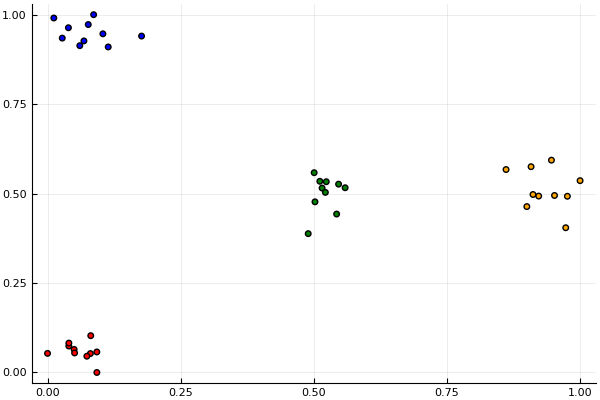

In [45]:
mcols = [:red, :blue, :green, :orange]
scatter(Xnor[:,1],Xnor[:,2], markercolor=mcols[Y], leg=false)

In [46]:
c_p = 0.1
max_depth = 3
K = 6
@time result = ClusterTree(Xnor,c_p,max_depth,K);

Academic license - for non-commercial use only
Status = Optimal
 89.657862 seconds (6.27 M allocations: 246.123 MiB, 0.38% gc time)



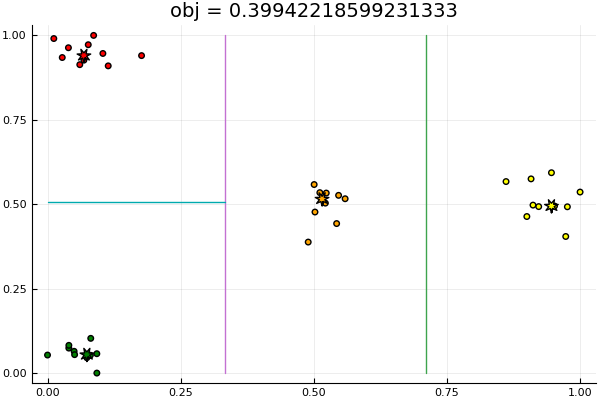

In [47]:
plot_cluster_tree(result,max_depth)

  0.000043 seconds (314 allocations: 21.750 KiB)



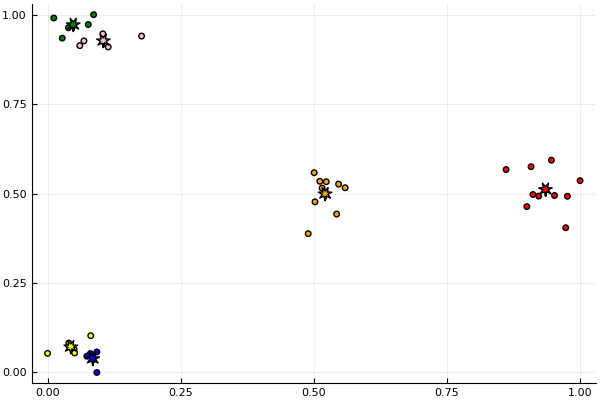

In [48]:
K = 6
@time kmeans_clusters = kmeans(Xnor',K)
mcols = [:red, :blue, :green, :orange, :pink, :yellow]
scatter(Xnor[:,1],Xnor[:,2], markercolor=mcols[assignments(kmeans_clusters)], leg=false)
scatter!(kmeans_clusters.centers[1,:],kmeans_clusters.centers[2,:], markercolor=mcols, m=[:star7], markersize = 10)

## Visualize tree

In [50]:
using GraphViz

In [51]:
function split_text(result)
    a = result["a"][:,:]'
    b = round.(result["b"][:],2)
    n, p = size(a)
    for i = 1:n
        result = string()
        for j = 1:p
            if a[i,j] != 0
                if isempty(result)
                    result = string(result,"$(a[i,j])","x$(j)")
                else
                    result = string(result," + ","$(a[i,j])","x$(j)")
                end
            end
        end
        result = string(result, " < $(b[i])")
        println(result)
    end
end

split_text (generic function with 1 method)

In [ ]:
function find_zero_nodes(result)
    
end

In [52]:
split_text(result)

1.0x1 < 0.71
1.0x1 < 0.33
 < 0.0
1.0x2 < 0.51
 < 0.0
 < 0.0
 < 0.0


In [59]:
result["branches"]

1:7

In [62]:
result["left parents"][2]

1-element Array{Any,1}:
 1

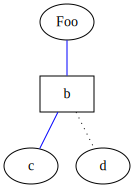

In [56]:
g = Graph("""
graph graphname {
     // The label attribute can be used to change the label of a node
     1 [label="Foo"];
     // Here, the node shape is changed.
     b [shape=box];
     // These edges both have different line properties
     a -- b -- c [color=blue];
     b -- d [style=dotted];
 }
""")
GraphViz.layout!(g; engine="dot")
g